In [38]:
# last edited Aug 2022 by GO
   
#
#############################################################################
# purpose: extract Ecospace grid file from NEMO grid file
#
# files in: NEMO-Salish-Sea-2021\data\grid\coordinates_salishsea_1500m.nc
#                                    bathy_salishsea_1500m_20210205.nc
# files out: shapefiles of NEMO and trimmed Ecospace grid
#            ASC file for Ecospace map
# 
# process: write bathy and coords grid from NC to SHP
#          open in ArcMap, determine upper and lower row and cols for trim
#          write trimmed depths to ASC
#
# Notes:  Used ArcMap to determine how to trim map for Ecospace.
#         Exported a copy of the NEMO and the Ecospace grids to SHP. 
#         Wrote to ASC. Fixed the vertical mirroring.     
#
# Ecospace header template: 
#ncols         56
#nrows         160
#xllcorner     -125.375
#yllcorner     45.2205657958984
#cellsize      0.0179964620620012
#NODATA_value  -9999
#############################################################################

%matplotlib notebook
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
from helpers import writebathy, expandf
from helpers import gete1, gete2, writecoords, t2u, t2v, t2f
import matplotlib.pyplot as plt
import scipy.io as sio

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for

<IPython.core.display.Javascript object>


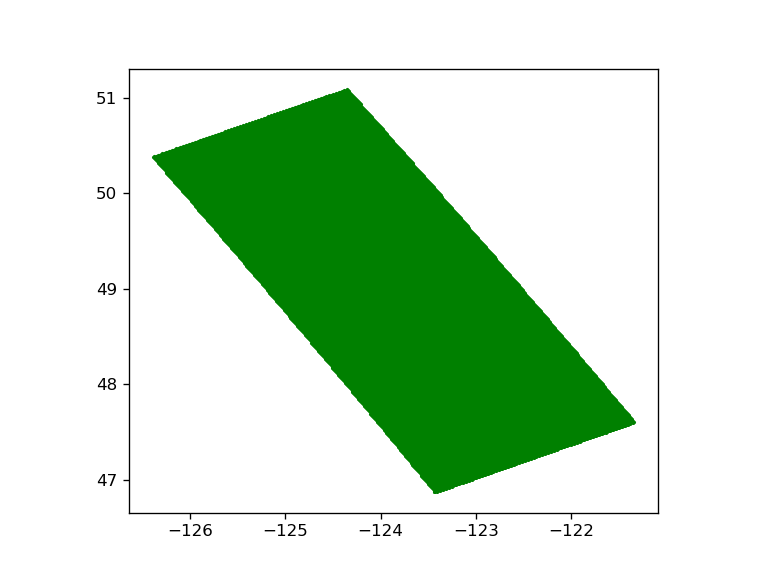

<IPython.core.display.Javascript object>


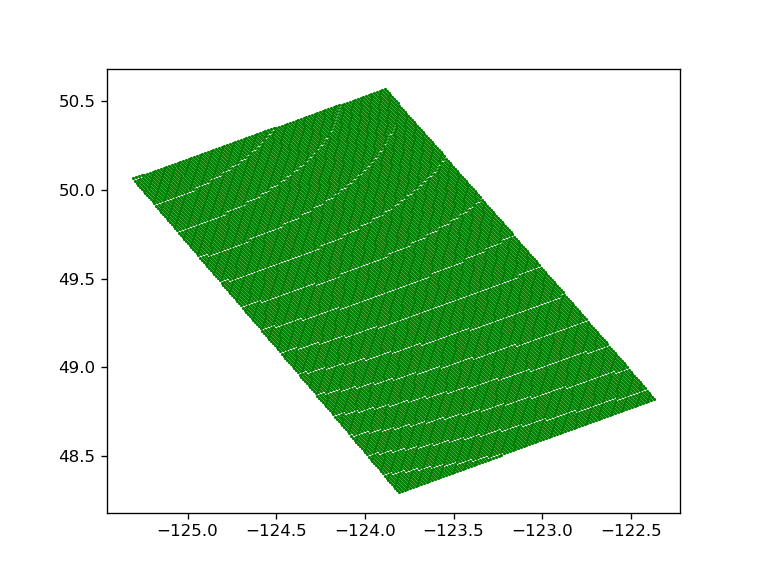

In [39]:
#For a full grid - coordfile
#for just water - bathy
coordfilename = '..//..//NEMO-Salish-Sea-2021//data//grid//coordinates_salishsea_1500m.nc'
bathyfilename = '..//..//NEMO-Salish-Sea-2021//data//bathymetry//bathy_salishsea_1500m_20210706.nc'
ecospaceoutfile = '..//data//basemap//ecospacedepthgrid.asc'
datetag = '20210208'


# functions
def loadcoords(f): 
    with nc.Dataset(coordfilename) as ncid:
        lat_t = ncid.variables["gphit"][0, :, :].filled()
        lon_t = ncid.variables["glamt"][0, :, :].filled()
    return lat_t, lon_t


def loadbathy(f):
    with nc.Dataset(f) as ncid:
        depth = ncid.variables["Bathymetry"][:, :].filled()
        latt = ncid.variables["nav_lat"][:, :].filled()
        lont = ncid.variables["nav_lon"][:, :].filled()
        
    return depth, latt, lont

#############################################################################
########################### EXPORT NEMO GRID SHP ############################
# get coords
depth, lat_t, lon_t = loadbathy(bathyfilename)

i = 0 
coords = []
while i < len(lat_t[:,0]):
    
    coords_row = [list(coord) for coord in zip(lat_t[i,:], 
                                               lon_t[i,:], 
                                               depth[i,:], 
                                               np.arange(0,lat_t.shape[1]), 
                                               np.full((lat_t.shape[1]), i))]
    #print(lat_t[i,:])
    #print(lon_t[i,:])
    coords = coords + coords_row
    i += 1
    
df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
gdf.plot( marker='*', color='green', markersize=1)
gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'col',4:'row'}, inplace=True)
#gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//NEMO_grid_{}.shp".format(datetag))

#############################################################################
################### Export Trimmed Ecospace Grid to SHP #####################
# - just to inspect

# NEMO grid upper left and bottom left pts that define the Ecospace grid. 
#   - Ecospace will use all cols to the right. 
upperleft_row_ewe = 253
upperleft_col_ewe = 39
bottomleft_row_ewe = 102
bottomleft_col_ewe = 39

# optional section 
i = bottomleft_row_ewe 
j = 0 
coords = []
while i < upperleft_row_ewe:
    
    coords_row = [list(coord) for coord in zip(lat_t[i,upperleft_col_ewe:], 
                                               lon_t[i,upperleft_col_ewe:], 
                                               depth[i,upperleft_col_ewe:], 
                                               np.arange(upperleft_col_ewe,lat_t.shape[1]), # list of col nums
                                               np.full(lat_t.shape[1], i))] # list of the row num i cols long
    coords = coords + coords_row
    
    # store the lower left lat / lon for Ecospace header
    if i == bottomleft_row_ewe:
        xllcorner = coords_row[0][1]
        yllcorner = coords_row[0][0]
    i += 1
    
df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[1],df[0]), crs="EPSG:4326")
gdf.plot( marker='*', color='green', markersize=1)
gdf.rename(columns={0:'lat',1:'lon',2: 'depth', 3:'NEMO_col',4:'NEMO_row'}, inplace=True)
#gdf.to_file(driver = 'ESRI Shapefile', filename= "..//data//basemap//Ecospace_grid_{}.shp".format(datetag))


In [4]:
#############################################################################
######################### EXPORT ECOSPACE ASC FILE ##########################
# - uses depths array

i = bottomleft_row_ewe 
j = 0 
coords = []
depthrows = []
print(type(depthrows))

while i < upperleft_row_ewe:
    depthrows.append(depth[i,upperleft_col_ewe:])
    i += 1

depthrows.reverse()

headerlines = []
headerlines.append(["ncols        " + str(len(depthrows[0]))])
headerlines.append(["nrows        " + str(len(depthrows))])
headerlines.append(["xllcorner    " + str(xllcorner)])
headerlines.append(["yllcorner    " + str(yllcorner)])
headerlines.append(["cellsize      0.013497347"])
headerlines.append(["NODATA_value  0.0"])

# when using 'with' the file is automatically closed by python io
with open(ecospaceoutfile,'w',encoding = 'utf-8') as f:
    for h in headerlines: 
        f.write(h[0])
        f.write("\n")
    for n in depthrows: 
        a_str = ' '.join(str(x.astype(int)) for x in n) # '0,3,5'
        f.write(a_str)
        f.write("\n")

<class 'list'>


# Just junk below

In [72]:
print(len(depthrows[0]))
print(len(depthrows))

93
151


In [15]:
"..//..//data//basemap//NEMO_grid_{}.shp".format(datetag)

'..//..//data//basemap//NEMO_grid_20210205.shp'

In [67]:
df

,0,1,2,3,4,geometry
0,48.294708,-123.807388,178.819444,39,102,POINT (-123.80739 48.29471)
1,48.300541,-123.791809,178.305556,40,102,POINT (-123.79181 48.30054)
2,48.306370,-123.776222,174.118056,41,102,POINT (-123.77622 48.30637)
3,48.312199,-123.760635,170.569444,42,102,POINT (-123.76064 48.31220)
4,48.318024,-123.745049,161.229167,43,102,POINT (-123.74505 48.31802)
...,...,...,...,...,...,...
14038,50.547035,-123.947533,0.000000,127,252,POINT (-123.94753 50.54704)
14039,50.552395,-123.932281,0.000000,128,252,POINT (-123.93228 50.55239)
14040,50.557755,-123.917030,0.000000,129,252,POINT (-123.91703 50.55775)
14041,50.563114,-123.901779,0.000000,130,252,POINT (-123.90178 50.56311)


In [4]:
gdf

,lat,lon,depth,NEMO_col,NEMO_row,geometry
0,48.294708,-123.807388,178.819444,39,102,POINT (-123.80739 48.29471)
1,48.300541,-123.791809,178.305556,40,102,POINT (-123.79181 48.30054)
2,48.306370,-123.776222,174.118056,41,102,POINT (-123.77622 48.30637)
3,48.312199,-123.760635,170.569444,42,102,POINT (-123.76064 48.31220)
4,48.318024,-123.745049,161.229167,43,102,POINT (-123.74505 48.31802)
...,...,...,...,...,...,...
14038,50.547035,-123.947533,0.000000,127,252,POINT (-123.94753 50.54704)
14039,50.552395,-123.932281,0.000000,128,252,POINT (-123.93228 50.55239)
14040,50.557755,-123.917030,0.000000,129,252,POINT (-123.91703 50.55775)
14041,50.563114,-123.901779,0.000000,130,252,POINT (-123.90178 50.56311)


In [76]:
xllcorner

-123.80739

<IPython.core.display.Javascript object>


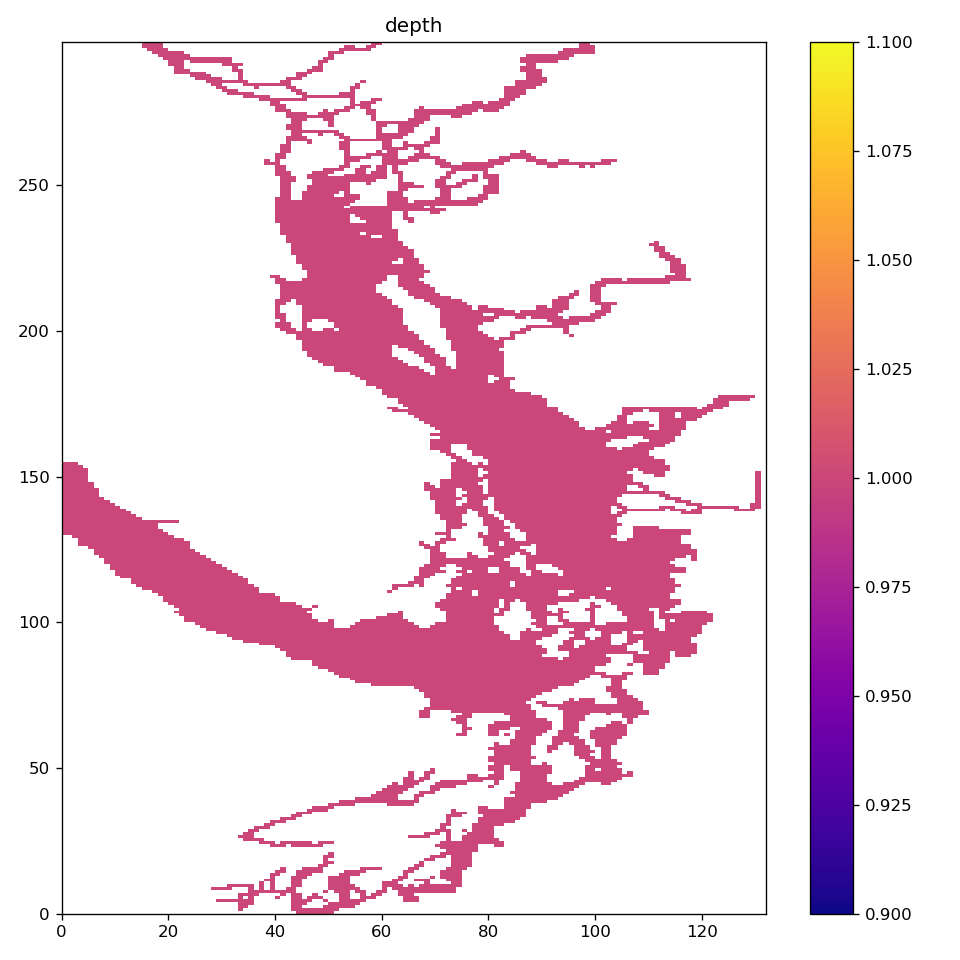

In [40]:
depth, lat_t, lon_t

# with nc.Dataset(f) as ncid:
#     depth = ncid.variables["Bathymetry"][:, :].filled()
#     latt = ncid.variables["nav_lat"][:, :].filled()
#     lont = ncid.variables["nav_lon"][:, :].filled()



depth[depth==0]=np.nan
depth[depth>0]=1
    #print(depth.shape)
    
    # can do edits below 
    # made permanent in the main create bathy above
    # north to south
    #depth[178,128] = 400 #northern fjord
#     depth[296,54] = 60 #northern fjord
#     depth[296,53] = 60 #northern fjord

plt.figure(figsize=(8,8))

plt.subplot(1,1,1)
plt.pcolormesh(depth, cmap=plt.plasma()); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(depth); plt.colorbar(); plt.title("depth")
    #plt.pcolormesh(ma_rorunoff, cmap=plt.pink()); plt.title("rodepth")
    
plt.tight_layout()
#plt.savefig(f.replace(".nc","_bathycheck.png"))


## just junk below

{'nav_lat': <class 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    bounds: bounds_nav_lat
unlimited dimensions: 
current shape = (299, 132)
filling on, default _FillValue of 9.969209968386869e+36 used, 'nav_lon': <class 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    bounds: bounds_nav_lon
unlimited dimensions: 
current shape = (299, 132)
filling on, default _FillValue of 9.969209968386869e+36 used, 'bounds_nav_lon': <class 'netCDF4._netCDF4.Variable'>
float32 bounds_nav_lon(y, x, nvertex)
unlimited dimensions: 
current shape = (299, 132, 4)
filling on, default _FillValue of 9.969209968386869e+36 used, 'bounds_nav_lat': <class 'netCDF4._netCDF4.Variable'>
float32 bounds_nav_lat(y, x, nvertex)
unlimited dimensions: 
current shape = (299, 132, 4)
filling on, default _FillValue of 9.969209968386869e+36 used, 'area': <class

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

<IPython.core.display.Javascript object>


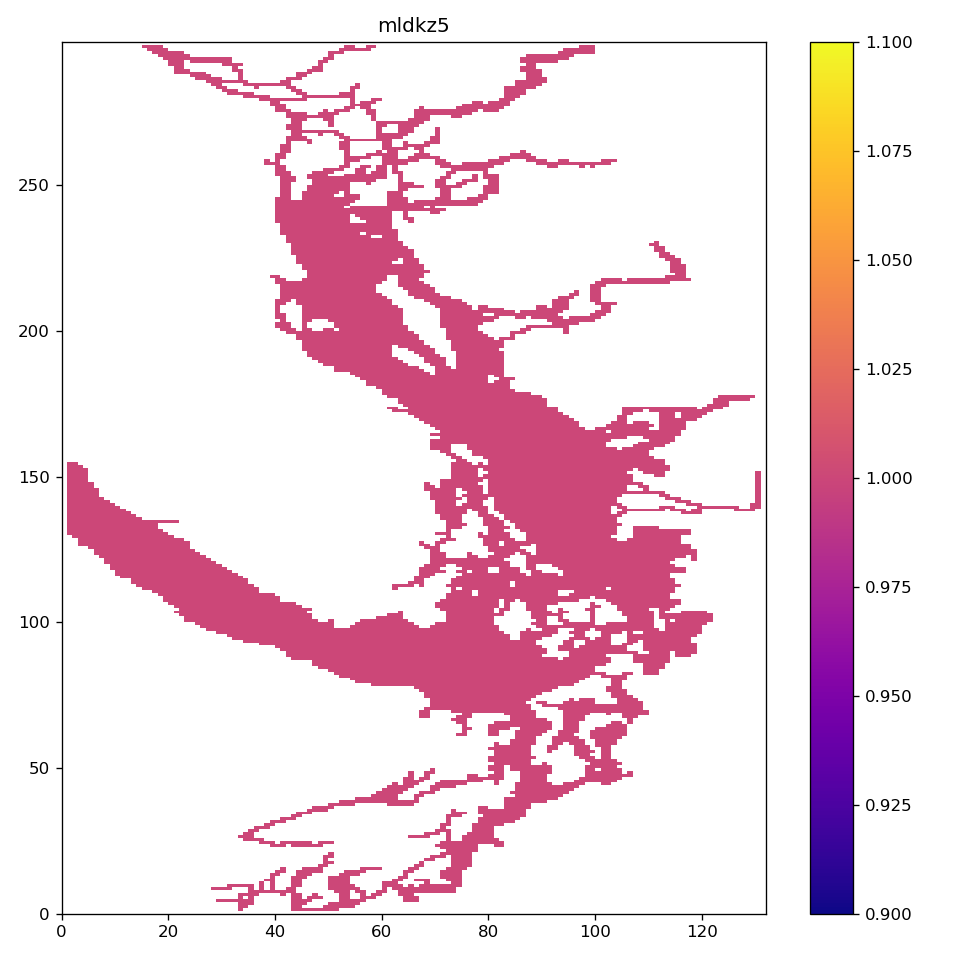

In [28]:
output_filename = '..//..//NEMO-Salish-Sea-2021//data//output//RUN203//SalishSea1500-RUN203_1d_grid_T_2D_y2017m10.nc'

with nc.Dataset(output_filename) as ncid:
    
    print(ncid.variables)
    mldkz5 = ncid.variables["mldkz5"][0,:, :].filled()
    mldr10_1 = ncid.variables["mldr10_1"][0,:, :].filled()
    latt = ncid.variables["nav_lat"][:, :].filled()
    lont = ncid.variables["nav_lon"][:, :].filled()

mldkz5.shape

mldkz5[mldkz5==0]=np.nan
mldkz5[mldkz5>0]=1

plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.pcolormesh(mldkz5, cmap=plt.plasma()); plt.colorbar(); plt.title("mldkz5")
    
plt.tight_layout()
#plt.savefig(f.replace(".nc","_bathycheck.png"))

In [34]:
mldr10_1.shape
np.min(mldr10_1)

0.0

In [25]:
depth.shape


(299, 132)

In [35]:
ncid.variables

RuntimeError: NetCDF: Not a valid ID

In [48]:
depth, lat_t, lon_t = loadbathy(bathyfilename)
depth[depth==0]=np.nan

np.nanmin(depth)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for

4.0